In [55]:
# Imports:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn import metrics

In [56]:
#Data taken from https://www.kaggle.com/datasets/heitornunes/caffeine-content-of-drinks
df = pd.read_csv('data/caffeine.csv') 
df.head()

,drink,Volume (ml),Calories,Caffeine (mg),type
0,Costa Coffee,256.993715,0,277,Coffee
1,Coffee Friend Brewed Coffee,250.191810,0,145,Coffee
2,Hell Energy Coffee,250.191810,150,100,Coffee
3,Killer Coffee (AU),250.191810,0,430,Coffee
4,Nescafe Gold,250.191810,0,66,Coffee


## My goal for this project is to make models to see if the algorithm can predict what type of drinks it is, based on a few key details given to us by the data set

In [57]:
df.isna().sum()

drink            0
Volume (ml)      0
Calories         0
Caffeine (mg)    0
type             0
dtype: int64

Let's see if there is a trend between the Values

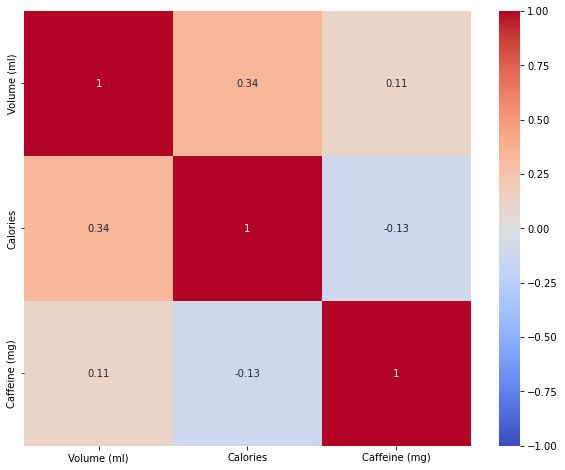

In [58]:
plt.figure(figsize = (10, 8))

sns.heatmap(df.corr(),
           cmap = 'coolwarm',
           annot = True,
           vmin = -1,
           vmax = 1);

plt.savefig('pics/heatmap1.png')

The main Correlation is between Calories and Volume

In [59]:
df['type'].unique()

array(['Coffee', 'Energy Drinks', 'Energy Shots', 'Soft Drinks', 'Tea',
       'Water'], dtype=object)

In [60]:
df['type_num'] = df['type'].map({'Coffee': 0, 'Energy Drinks': 1, 'Energy Shots': 2, 'Soft Drinks': 3, 'Tea': 4, 'Water': 5})

In [61]:
df.head()

,drink,Volume (ml),Calories,Caffeine (mg),type,type_num
0,Costa Coffee,256.993715,0,277,Coffee,0
1,Coffee Friend Brewed Coffee,250.191810,0,145,Coffee,0
2,Hell Energy Coffee,250.191810,150,100,Coffee,0
3,Killer Coffee (AU),250.191810,0,430,Coffee,0
4,Nescafe Gold,250.191810,0,66,Coffee,0


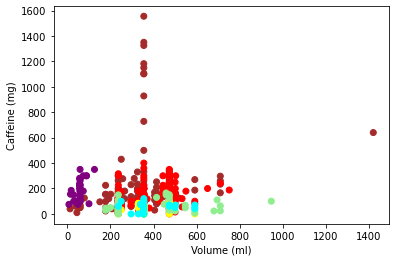

In [62]:
# matplotlib KNN visualization

colors = {0: 'brown', 1:'red', 2:'purple', 3: 'yellow', 4: 'lightgreen', 5: 'aqua'}

color_series = df['type_num'].map(colors)

plt.scatter(df['Volume (ml)'],
           df['Caffeine (mg)'],
           color = color_series)

plt.xlabel('Volume (ml)')
plt.ylabel('Caffeine (mg)');

plt.savefig('pics/knn.png')

It seems that there may be some correlation between caffeine content and weather the drink is coffee or not. Let's make some dummy variables

In [63]:
df_dummies = pd.get_dummies(data=df.drop(columns=['type_num']), columns=['type'])
df_dummies.head()

,drink,Volume (ml),Calories,Caffeine (mg),type_Coffee,type_Energy Drinks,type_Energy Shots,type_Soft Drinks,type_Tea,type_Water
0,Costa Coffee,256.993715,0,277,1,0,0,0,0,0
1,Coffee Friend Brewed Coffee,250.191810,0,145,1,0,0,0,0,0
2,Hell Energy Coffee,250.191810,150,100,1,0,0,0,0,0
3,Killer Coffee (AU),250.191810,0,430,1,0,0,0,0,0
4,Nescafe Gold,250.191810,0,66,1,0,0,0,0,0


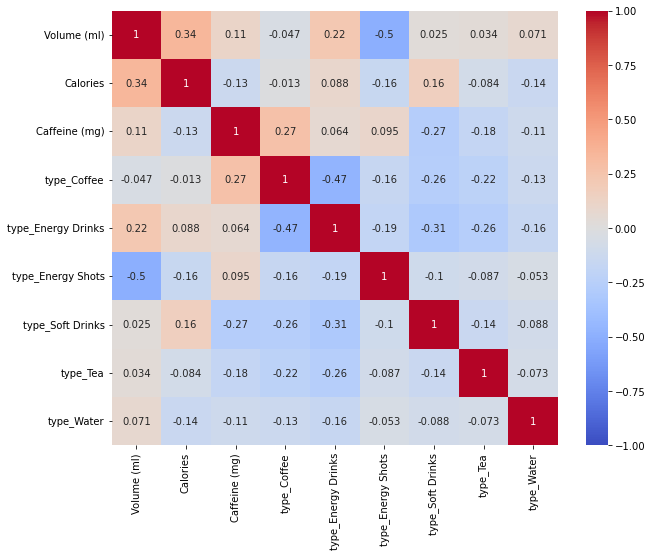

In [64]:
plt.figure(figsize = (10, 8))

sns.heatmap(df_dummies.corr(),
           cmap = 'coolwarm',
           annot = True,
           vmin = -1,
           vmax = 1);

plt.savefig('pics/heatmap2.png')

We see a strong negative correlation between energy shots and volume which is understandable. We also see that Coffee is most highly correlated with high caffeine count.

Let's see if we can predict the drink type based on the 3 metrics. We will see if we can predict if the drink is coffee or not.

In [65]:
df.head()

,drink,Volume (ml),Calories,Caffeine (mg),type,type_num
0,Costa Coffee,256.993715,0,277,Coffee,0
1,Coffee Friend Brewed Coffee,250.191810,0,145,Coffee,0
2,Hell Energy Coffee,250.191810,150,100,Coffee,0
3,Killer Coffee (AU),250.191810,0,430,Coffee,0
4,Nescafe Gold,250.191810,0,66,Coffee,0


In [66]:
df = df.drop(columns = ['type_num'])
df['coffee'] = df['type'].map(lambda x: 1 if x == 'Coffee' else 0)
df.head()

,drink,Volume (ml),Calories,Caffeine (mg),type,coffee
0,Costa Coffee,256.993715,0,277,Coffee,1
1,Coffee Friend Brewed Coffee,250.191810,0,145,Coffee,1
2,Hell Energy Coffee,250.191810,150,100,Coffee,1
3,Killer Coffee (AU),250.191810,0,430,Coffee,1
4,Nescafe Gold,250.191810,0,66,Coffee,1


In [67]:
# Check our baseline
y = df['coffee']
y.value_counts(normalize=True)

0    0.716393
1    0.283607
Name: coffee, dtype: float64

The model must be able to perform better than 71.6% accurate.

In [68]:
df.corr()['coffee']

Volume (ml)     -0.046754
Calories        -0.013489
Caffeine (mg)    0.267086
coffee           1.000000
Name: coffee, dtype: float64

Below is the best model I could come up with based on the data. I created a logistic regression model because the answer is either a 1 or a 0 based on numerical variables

In [69]:
X = df[['Volume (ml)', 'Calories', 'Caffeine (mg)']]

In [70]:
poly = PolynomialFeatures(include_bias = False, degree = 2)

In [71]:
X_poly = poly.fit_transform(X)

In [72]:
# Split the data into the training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X_poly, y, random_state = 42)

In [73]:
#Logistic Regression
log_r = LogisticRegression()

In [74]:
log_r.fit(X_train, y_train)

C:\Users\matth\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [75]:
print(f'Training R2: {log_r.score(X_train, y_train)}')
print(f'Testing R2: {log_r.score(X_test, y_test)}')

Training R2: 0.7352297592997812
Testing R2: 0.738562091503268


While this model is neither overfit or underfit, it's only marginally better than the baseline.

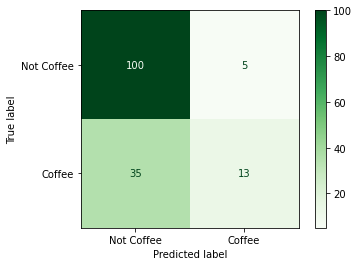

In [76]:
# https://github.com/justmarkham/scikit-learn-tips/blob/master/notebooks/20_plot_confusion_matrix.ipynb
plot_confusion_matrix(log_r, X_test, y_test, cmap = 'Greens', display_labels = ['Not Coffee', 'Coffee']);

plt.savefig('pics/coffee_reg.png')

Looking at this confusion matrix, we see that it can guess not coffee better than it can guess coffee. 

Looking at the names of the drinks, at least in the head, we see that the word coffee appears a lot in coffee drinks. Perhaps we can find a better model as a classification model that looks at the names of the drinks.

In [77]:
X = df['drink']

In [78]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

In [79]:
pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('nb', MultinomialNB())
])

In [80]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('cvec', CountVectorizer()), ('nb', MultinomialNB())])

In [81]:
print('Train:', pipe.score(X_train, y_train))
print('Test:', pipe.score(X_test, y_test))

Train: 0.986870897155361
Test: 0.9411764705882353


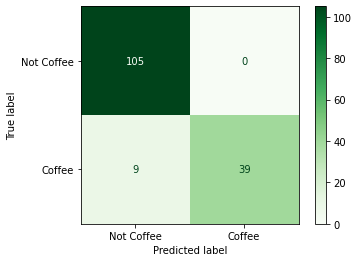

In [82]:
# Confusion matrix
plot_confusion_matrix(pipe, X_test, y_test, cmap='Greens', display_labels = ['Not Coffee', 'Coffee'])

plt.savefig('pics/coffee_class.png')

Here we can see that out of the 153 entries, the model got all but 9 correct. This is a good model.

Now that we did that for coffee, let's make a similar model for the other drink types and see if the model is accurate.

In [83]:
df_dummies.head()

,drink,Volume (ml),Calories,Caffeine (mg),type_Coffee,type_Energy Drinks,type_Energy Shots,type_Soft Drinks,type_Tea,type_Water
0,Costa Coffee,256.993715,0,277,1,0,0,0,0,0
1,Coffee Friend Brewed Coffee,250.191810,0,145,1,0,0,0,0,0
2,Hell Energy Coffee,250.191810,150,100,1,0,0,0,0,0
3,Killer Coffee (AU),250.191810,0,430,1,0,0,0,0,0
4,Nescafe Gold,250.191810,0,66,1,0,0,0,0,0


Energy Drinks:

In [84]:
X = df_dummies['drink']
y = df_dummies['type_Energy Drinks']

In [85]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

In [86]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('cvec', CountVectorizer()), ('nb', MultinomialNB())])

In [87]:
print('Train:', pipe.score(X_train, y_train))
print('Test:', pipe.score(X_test, y_test))

Train: 0.9715536105032823
Test: 0.9281045751633987


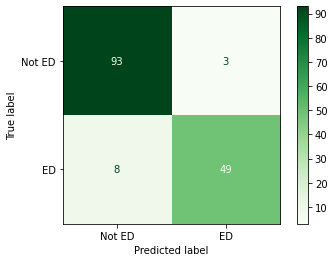

In [88]:
# Confusion matrix
plot_confusion_matrix(pipe, X_test, y_test, cmap='Greens', display_labels = ['Not ED', 'ED'])

plt.savefig('pics/ed.png')

Energy Shots:

In [89]:
y = df_dummies['type_Energy Shots']

In [90]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

In [91]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('cvec', CountVectorizer()), ('nb', MultinomialNB())])

In [92]:
print('Train:', pipe.score(X_train, y_train))
print('Test:', pipe.score(X_test, y_test))

Train: 1.0
Test: 0.9803921568627451


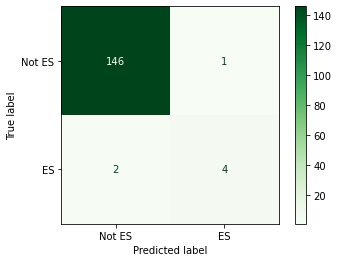

In [93]:
# Confusion matrix
plot_confusion_matrix(pipe, X_test, y_test, cmap='Greens', display_labels = ['Not ES', 'ES'])

plt.savefig('pics/es.png')

Soft Drinks:

In [94]:
y = df_dummies['type_Soft Drinks']

In [95]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

In [96]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('cvec', CountVectorizer()), ('nb', MultinomialNB())])

In [97]:
print('Train:', pipe.score(X_train, y_train))
print('Test:', pipe.score(X_test, y_test))

Train: 0.9781181619256017
Test: 0.9607843137254902


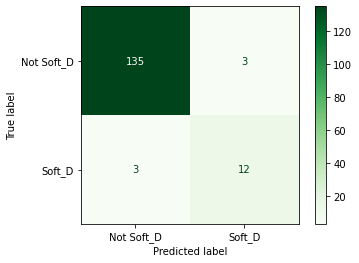

In [98]:
# Confusion matrix
plot_confusion_matrix(pipe, X_test, y_test, cmap='Greens', display_labels = ['Not Soft_D', 'Soft_D'])

plt.savefig('pics/soft_d.png')

Tea:

In [99]:
y = df_dummies['type_Tea']

In [100]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

In [101]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('cvec', CountVectorizer()), ('nb', MultinomialNB())])

In [102]:
print('Train:', pipe.score(X_train, y_train))
print('Test:', pipe.score(X_test, y_test))

Train: 0.9934354485776805
Test: 0.9869281045751634


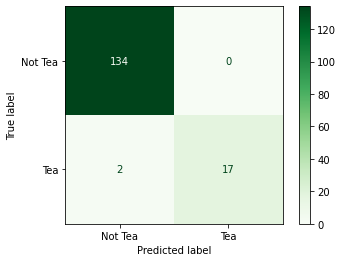

In [103]:
# Confusion matrix
plot_confusion_matrix(pipe, X_test, y_test, cmap='Greens', display_labels = ['Not Tea', 'Tea'])

plt.savefig('pics/tea.png')

Water:

In [104]:
y = df_dummies['type_Water']

In [105]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

In [106]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('cvec', CountVectorizer()), ('nb', MultinomialNB())])

In [107]:
print('Train:', pipe.score(X_train, y_train))
print('Test:', pipe.score(X_test, y_test))

Train: 1.0
Test: 0.9869281045751634


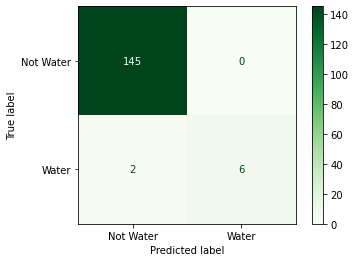

In [108]:
# Confusion matrix
plot_confusion_matrix(pipe, X_test, y_test, cmap='Greens', display_labels = ['Not Water', 'Water'])

plt.savefig('pics/water.png')

All of these models are good

#### Conclusion: While it is difficult to tell what type of drink it is based on volume, calories, and caffiene content, we can based on the label. What this tells us is 2 things:
1. Companies label their products properly
2. All categories of drinks that boost you up have similar specs. So choose the drink that fits you best!